In [1]:
import jaxtromet
import jax
import jax.numpy as jnp
from astropy.time import Time
import numpy as np
from jax.config import config
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

In [2]:
SOURCE_ID: int = 2467955656448455040

RA = 184.436272761
DEC = -59.029414780
KAPPA = 8.144
BASELINE_G = 19.
BLENDING_G = 1

In [3]:
import scanninglaw.times
from scanninglaw.source import Source
from scanninglaw.config import config

In [4]:
SCANNING_TIMES = scanninglaw.times.Times(version='dr3_nominal')

Loading auxilliary data ...
t = 21.013 s
  auxilliary:  10.767 s
          sf:   3.395 s
interpolator:   6.850 s


In [5]:
import astromet

def generate_params_qso(ra: np.float64,
                        dec: np.float64,
                        pi_l: np.float64,
                        pm_l_ra: np.float64,
                        pm_l_dec: np.float64,
                        mass: np.float64,
                        u_0: np.float64,
                        t_0: np.float64
                        ) -> dict:
    pi_rel = pi_l
    pm_rel_ra = pm_l_ra
    pm_rel_dec = pm_l_dec
    pm_rel = np.sqrt(pm_rel_ra*pm_rel_ra+pm_rel_dec*pm_rel_dec)
    theta_E = np.sqrt(KAPPA*mass*pi_l)
    t_E = (theta_E/pm_rel)*365.25
    pi_E = pi_l/theta_E
    pm_s_ra = 1e-18
    pm_s_dec = 1e-18
    pi_s = 1e-18
    # pm_s_ra = 1
    # pm_s_dec = 1
    # pi_s = 0.1
    comp_E = pm_rel_ra/pm_rel
    comp_N = pm_rel_dec/pm_rel
    pi_EE = pi_E*comp_E
    pi_EN = pi_E*comp_N
    return dict(jaxtromet.define_lens(ra, dec,
                                   u_0,
                                   t_0,
                                   t_E,
                                   pi_EN,
                                   pi_EE,
                                   BLENDING_G,
                                   pm_s_ra,
                                   pm_s_dec,
                                   1/pi_s,
                                   theta_E))


def generate_params_qso_astromet(ra: np.float64,
                        dec: np.float64,
                        pi_l: np.float64,
                        pm_l_ra: np.float64,
                        pm_l_dec: np.float64,
                        mass: np.float64,
                        u_0: np.float64,
                        t_0: np.float64
                        ) -> dict:
    pi_rel = pi_l
    pm_rel_ra = pm_l_ra
    pm_rel_dec = pm_l_dec
    pm_rel = np.sqrt(pm_rel_ra*pm_rel_ra+pm_rel_dec*pm_rel_dec)
    theta_E = np.sqrt(KAPPA*mass*pi_l)
    t_E = (theta_E/pm_rel)*365.25
    pi_E = pi_l/theta_E
    pm_s_ra = 1e-18
    pm_s_dec = 1e-18
    pi_s = 1e-18
    # pm_s_ra = 1
    # pm_s_dec = 1
    # pi_s = 0.1
    comp_E = pm_rel_ra/pm_rel
    comp_N = pm_rel_dec/pm_rel
    pi_EE = pi_E*comp_E
    pi_EN = pi_E*comp_N
    return astromet.define_lens(astromet.params(),
                                ra=ra, dec=dec,
                                u0=u_0,
                                t0=t_0,
                                tE=t_E,
                                piEN=pi_EN,
                                piEE=pi_EE,
                                m0=BASELINE_G,
                                fbl=BLENDING_G,
                                pmrac_source=pm_s_ra,
                                pmdec_source=pm_s_dec,
                                d_source=1/pi_s,
                                thetaE=theta_E)


def generate_params_qso_astromet_n(ra: np.float64,
                        dec: np.float64,
                        pi_l: np.float64,
                        pm_l_ra: np.float64,
                        pm_l_dec: np.float64,
                        mass: np.float64,
                        u_0: np.float64,
                        t_0: np.float64
                        ) -> dict:
    pi_rel = pi_l
    pm_rel_ra = pm_l_ra
    pm_rel_dec = pm_l_dec
    pm_rel = np.sqrt(pm_rel_ra*pm_rel_ra+pm_rel_dec*pm_rel_dec)
    theta_E = np.sqrt(KAPPA*mass*pi_l)
    t_E = (theta_E/pm_rel)*365.25
    pi_E = pi_l/theta_E
    pm_s_ra = 1e-18
    pm_s_dec = 1e-18
    pi_s = 1e-18
    # pm_s_ra = 1
    # pm_s_dec = 1
    # pi_s = 0.1
    comp_E = pm_rel_ra/pm_rel
    comp_N = pm_rel_dec/pm_rel
    pi_EE = pi_E*comp_E
    pi_EN = pi_E*comp_N
    return astromet.define_lens(astromet.params(),
                                ra=ra, dec=dec,
                                u0=u_0,
                                t0=t_0,
                                tE=t_E,
                                piEN=pi_EN,
                                piEE=pi_EE,
                                m0=BASELINE_G,
                                fbl=BLENDING_G,
                                pmrac_source=pm_s_ra,
                                pmdec_source=pm_s_dec,
                                d_source=1/pi_s,
                                thetaE=1e-10)

In [6]:
def define_lensed_quasar(ra, dec, mass_l, pi_lens,
                         pmrac_lens, pmdec_lens, t_0, u_0,
                         epoch: float = 2016.):
    """
    Defines astromet parameters for a microlensed quasar with assumed
    parallax and proper motions of zero and a dark lens (blending=1)
    Args:
        - ra            float - right ascension, deg
        - dec           float - declination, deg
        - mass_l        float - lens mass in solar masses
        - pi_lens       float - lens parallax in mas
        - pmrac_lens    float - lens proper motion in rac direction in mas/yr
        - pmdec_lens    float - lens proper motion in dec direction in mas/yr
        - t_0           float - closest approach time in decimal year
        - u_0           float - closest approach distance on the sky in theta_E # TODO: change it to beta_0
    Returns:
        - params        astromet parameters
    """
    params = {}

    params['drac'] = 0  # mas
    params['ddec'] = 0  # mas

    # binary parameters
    # left default for a non-binary system
    params['period'] = 1  # year
    params['a'] = 0  # AU
    params['e'] = 0.1
    params['q'] = 0
    params['l'] = 0  # assumed < 1 (though may not matter)
    params['vtheta'] = jnp.pi / 4
    params['vphi'] = jnp.pi / 4
    params['vomega'] = 0
    params['tperi'] = 0  # jyear

    # blend parameters
    params['blenddrac'] = 0  # mas
    params['blendddec'] = 0  # mas

    # Below are assumed to be derived from other params
    # (I.e. not(!) specified by user)
    params['totalmass'] = -1  # solar mass
    params['Delta'] = -1

    # the epoch determines when RA and Dec (and other astrometry)
    # are centred - for dr3 it's 2016.0, dr2 2015.5, dr1 2015.0
    params['epoch'] = epoch
    
    params['ra'] = ra
    params['dec'] = dec

    # source motion
    params['parallax'] = 0.
    params['pmrac'] = 0.
    params['pmdec'] = 0.

    # lens motion
    params['blendparallax'] = pi_lens
    params['blendpmrac'] = pmrac_lens
    params['blendpmdec'] = pmdec_lens

    # lensing event
    params['thetaE'] = jnp.sqrt(KAPPA*mass_l*pi_lens)
    params['blendl'] = 0.

   #t_0 = Time(t_0+2450000, format='jd').decimalyear
    mu_rel = jnp.array([params['pmrac'] - params['blendpmrac'],
                       params['pmdec'] - params['blendpmdec']])
    offset_t0 = mu_rel*(t_0-params['epoch'])
    offset_u0_dir = jnp.array([mu_rel[1], -mu_rel[0]])
    offset_u0 = offset_u0_dir/jnp.linalg.norm(offset_u0_dir) * (u_0*params['thetaE'])  # separation at t0
    offset_mas = offset_t0 - offset_u0
    params['blenddrac'], params['blendddec'] = offset_mas[0], offset_mas[1]

    return params

In [7]:
def define_lensed_quasar_no_lens(ra, dec, mass_l, pi_lens,
                         pmrac_lens, pmdec_lens, t_0, u_0,
                         epoch: float = 2016.):
    """
    Defines astromet parameters for a microlensed quasar with assumed
    parallax and proper motions of zero and a dark lens (blending=1)
    Args:
        - ra            float - right ascension, deg
        - dec           float - declination, deg
        - mass_l        float - lens mass in solar masses
        - pi_lens       float - lens parallax in mas
        - pmrac_lens    float - lens proper motion in rac direction in mas/yr
        - pmdec_lens    float - lens proper motion in dec direction in mas/yr
        - t_0           float - closest approach time in decimal year
        - u_0           float - closest approach distance on the sky in theta_E # TODO: change it to beta_0
    Returns:
        - params        astromet parameters
    """
    params = {}

    params['drac'] = 0  # mas
    params['ddec'] = 0  # mas

    # binary parameters
    # left default for a non-binary system
    params['period'] = 1  # year
    params['a'] = 0  # AU
    params['e'] = 0.1
    params['q'] = 0
    params['l'] = 0  # assumed < 1 (though may not matter)
    params['vtheta'] = jnp.pi / 4
    params['vphi'] = jnp.pi / 4
    params['vomega'] = 0
    params['tperi'] = 0  # jyear

    # blend parameters
    params['blenddrac'] = 0  # mas
    params['blendddec'] = 0  # mas

    # Below are assumed to be derived from other params
    # (I.e. not(!) specified by user)
    params['totalmass'] = -1  # solar mass
    params['Delta'] = -1

    # the epoch determines when RA and Dec (and other astrometry)
    # are centred - for dr3 it's 2016.0, dr2 2015.5, dr1 2015.0
    params['epoch'] = epoch
    
    params['ra'] = ra
    params['dec'] = dec

    # source motion
    params['parallax'] = 0.
    params['pmrac'] = 0.
    params['pmdec'] = 0.

    # lens motion
    params['blendparallax'] = pi_lens
    params['blendpmrac'] = pmrac_lens
    params['blendpmdec'] = pmdec_lens

    # lensing event
    params['thetaE'] = 1e-10
    params['blendl'] = 0.

   #t_0 = Time(t_0+2450000, format='jd').decimalyear
    mu_rel = jnp.array([params['pmrac'] - params['blendpmrac'],
                       params['pmdec'] - params['blendpmdec']])
    offset_t0 = mu_rel*(t_0-params['epoch'])
    offset_u0_dir = jnp.array([mu_rel[1], -mu_rel[0]])
    offset_u0 = offset_u0_dir/jnp.linalg.norm(offset_u0_dir) * (u_0*params['thetaE'])  # separation at t0
    offset_mas = offset_t0 - offset_u0
    params['blenddrac'], params['blendddec'] = offset_mas[0], offset_mas[1]

    return params

In [8]:
my_params = define_lensed_quasar(184.436, -59.029, 10, 0.1, -5, -2., 2016., 1)
my_params_n = define_lensed_quasar_no_lens(184.436, -59.029, 10, 0.1, -5, -2., 2016., 1)

In [9]:
params_compare_astromet = generate_params_qso_astromet(184.426, -59.029, 1/10, -5, -2, 10, 1, 7389)
params_compare_astromet_n = generate_params_qso_astromet_n(184.426, -59.029, 1/10, -5, -2, 10, 1, 7389)

In [10]:
def generate_times(ra, dec):
    # get Gaia scanning pattern for the field
    c = Source(ra,
               dec,
               unit='deg')
    sl = SCANNING_TIMES(c,
                        return_times=True,
                        return_angles=True)
    ts = 2010 + np.squeeze(np.hstack(sl['times']))/365.25
    
    sorted_arg_ts = np.argsort(ts)
    
    ts = np.double(ts[sorted_arg_ts])
    phis = np.double(np.squeeze(np.hstack(sl['angles']))[sorted_arg_ts])
    
    return ts, phis

In [11]:
# TODO: write utility functions for those
# for now, these are global
ra1, dec1 = 184.426, -59.029

times, phis = generate_times(ra1, dec1)
times = jnp.array(times)
phis = jnp.array(phis)
barypos = jaxtromet.barycentricPosition(times)

In [12]:
ras, decs, mag_diff = jaxtromet.track(times, barypos, my_params)
rasn, decsn, mag_diffn = jaxtromet.track(times, barypos, my_params_n)

In [13]:
ras1a, decs1a, mag_diff1a = astromet.track(times, params_compare_astromet)
ras1an, decs1an, mag_diffn = astromet.track(times, params_compare_astromet_n)

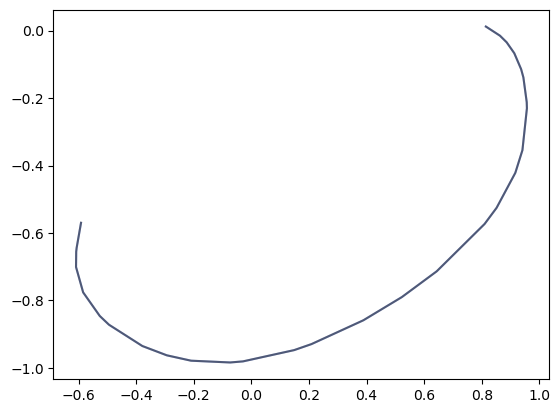

In [14]:
plt.plot(ras, decs, color='royalblue', alpha=0.5)
plt.plot(rasn, decsn, color='green')
plt.plot(ras1an, decs1an, color='firebrick', alpha=0.5)
plt.plot(ras1a, decs1a, color='black', alpha=0.5)

In [15]:
t_obs, x_obs, phi_obs, rac_obs, dec_obs = jaxtromet.mock_obs(times,
                                                            phis,
                                                            ras,
                                                            decs)

In [16]:
t_obs, x_obsn, phi_obs, rac_obsn, dec_obsn = jaxtromet.mock_obs(times,
                                                            phis,
                                                            rasn,
                                                            decsn,)

In [17]:
t_obs1a, x_obs1a, phi_obs1a, rac_obs1a, dec_obs1a = astromet.mock_obs(times,
                                                            phis,
                                                            ras1a,
                                                            decs1a)

In [18]:
t_obs1an, x_obs1an, phi_obs1an, rac_obs1an, dec_obs1an = astromet.mock_obs(times,
                                                            phis,
                                                            ras1an,
                                                            decs1an)

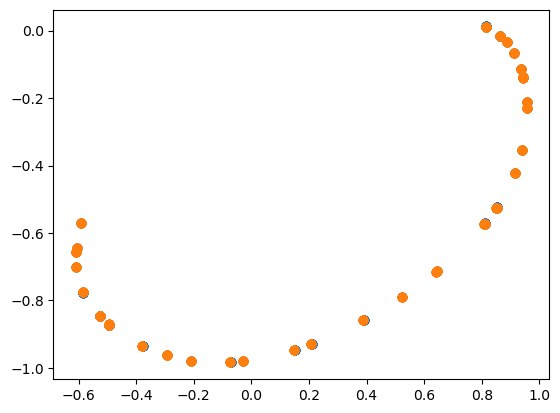

In [19]:
plt.scatter(rac_obs, dec_obs)
plt.scatter(rac_obs1a, dec_obs1a)

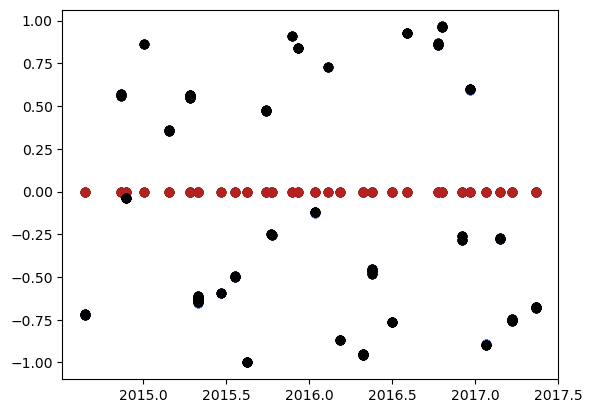

In [20]:
plt.scatter(t_obs, x_obs, color='royalblue', alpha=.5)
plt.scatter(t_obs, x_obsn, color='green', alpha=.5)

plt.scatter(t_obs1an, x_obs1an, color='firebrick', alpha=.5)
plt.scatter(t_obs1a, x_obs1a, color='black', alpha=.5)

In [21]:
jaxtromet.gaia_results(jaxtromet.fit(t_obs, jaxtromet.barycentricPosition(t_obs), x_obs, phi_obs, jaxtromet.sigma_ast(BASELINE_G), RA, DEC, G=BASELINE_G))

{'visibility_periods_used': DeviceArray(28, dtype=int64),
 'astrometric_n_obs_al': DeviceArray(585, dtype=int64, weak_type=True),
 'ra': DeviceArray(184.43627269, dtype=float64),
 'ra_error': DeviceArray(0.13737893, dtype=float64),
 'dec': DeviceArray(-59.02941493, dtype=float64),
 'dec_error': DeviceArray(0.1490148, dtype=float64),
 'ra_dec_corr': DeviceArray(0.25127661, dtype=float64),
 'parallax': DeviceArray(0.00875943, dtype=float64),
 'parallax_error': DeviceArray(0.19203106, dtype=float64),
 'ra_parallax_corr': DeviceArray(-0.10686543, dtype=float64),
 'dec_parallax_corr': DeviceArray(-0.05727124, dtype=float64),
 'pmra': DeviceArray(0.72035649, dtype=float64),
 'pmra_error': DeviceArray(0.17804963, dtype=float64),
 'ra_pmra_corr': DeviceArray(-0.17326055, dtype=float64),
 'dec_pmra_corr': DeviceArray(0.07331423, dtype=float64),
 'parallax_pmra_corr': DeviceArray(0.10115413, dtype=float64),
 'pmdec': DeviceArray(0.32313447, dtype=float64),
 'pmdec_error': DeviceArray(0.18603837,

In [22]:
astromet.gaia_results(astromet.fit(t_obs1a, x_obs1a, phi_obs1a, astromet.sigma_ast(BASELINE_G), RA, DEC, G=BASELINE_G))

{'astrometric_matched_transits': 65,
 'visibility_periods_used': 28,
 'astrometric_n_obs_al': 585,
 'astrometric_params_solved': 31,
 'ra': 184.43627269007314,
 'ra_error': 0.13737894292548733,
 'dec': -59.02941493439843,
 'dec_error': 0.14901481340680972,
 'ra_dec_corr': 0.2512766123407519,
 'parallax': 0.008794228781223018,
 'parallax_error': 0.1920310809480652,
 'ra_parallax_corr': -0.10686542631642629,
 'dec_parallax_corr': -0.05727124027059476,
 'pmra': 0.7208604987146588,
 'pmra_error': 0.1780496462817467,
 'ra_pmra_corr': -0.17326054923271336,
 'dec_pmra_corr': 0.07331422809727105,
 'parallax_pmra_corr': 0.10115412705641799,
 'pmdec': 0.3224508323439449,
 'pmdec_error': 0.18603838263866682,
 'ra_pmdec_corr': 0.046459722115022736,
 'dec_pmdec_corr': 0.03860936105458703,
 'parallax_pmdec_corr': 0.14209664227856025,
 'pmra_pmdec_corr': 0.3086652773387436,
 'astrometric_excess_noise': 0.0,
 'astrometric_chi2_al': 6.24513594009748,
 'astrometric_n_good_obs_al': 585,
 'uwe': 0.1037664

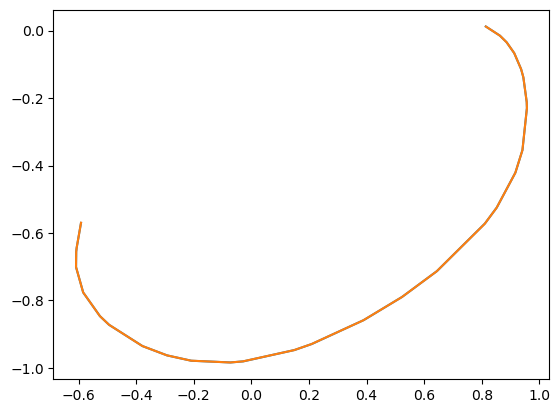

In [23]:
plt.plot(rac_obs, dec_obs)
plt.plot(rac_obs1a, dec_obs1a)

# Reproducing Łukasz's results

# Slow lens

In [24]:
different_masses = jax.vmap(lambda x: define_lensed_quasar(RA, DEC, x, .1, 1., 1.), in_axes=(0,))(jnp.logspace(-2, 7, 100))

NameError: name 'get_astrometric_params_for_params' is not defined

In [ ]:
different_pms = jax.vmap(lambda x: get_astrometric_params_for_params(100, .1, x, x), in_axes=(0,))(jnp.linspace(0.1, 100, 100))

In [ ]:
different_parallaxes = jax.vmap(lambda x: get_astrometric_params_for_params(100, x, 1., 1.), in_axes=(0,))(jnp.logspace(-5, 1, 100))

In [ ]:
different_masses = np.array(different_masses)
masses = np.logspace(-2, 7, 100)

In [ ]:
different_parallaxes = np.array(different_parallaxes)
parallaxes = np.logspace(-5, 1, 100)

In [ ]:
different_pms = np.array(different_pms)
pms = np.linspace(0.1, 100, 100)

In [ ]:
years = np.linspace(2000., 2020., 100)
different_years = jax.vmap(get_astrometric_params_for_year)(jnp.array(years))

In [ ]:
beta_0s = np.logspace(-2, 2, 100)
different_beta_0s = jax.vmap(get_astrometric_params_for_beta_0)(jnp.array(beta_0s))

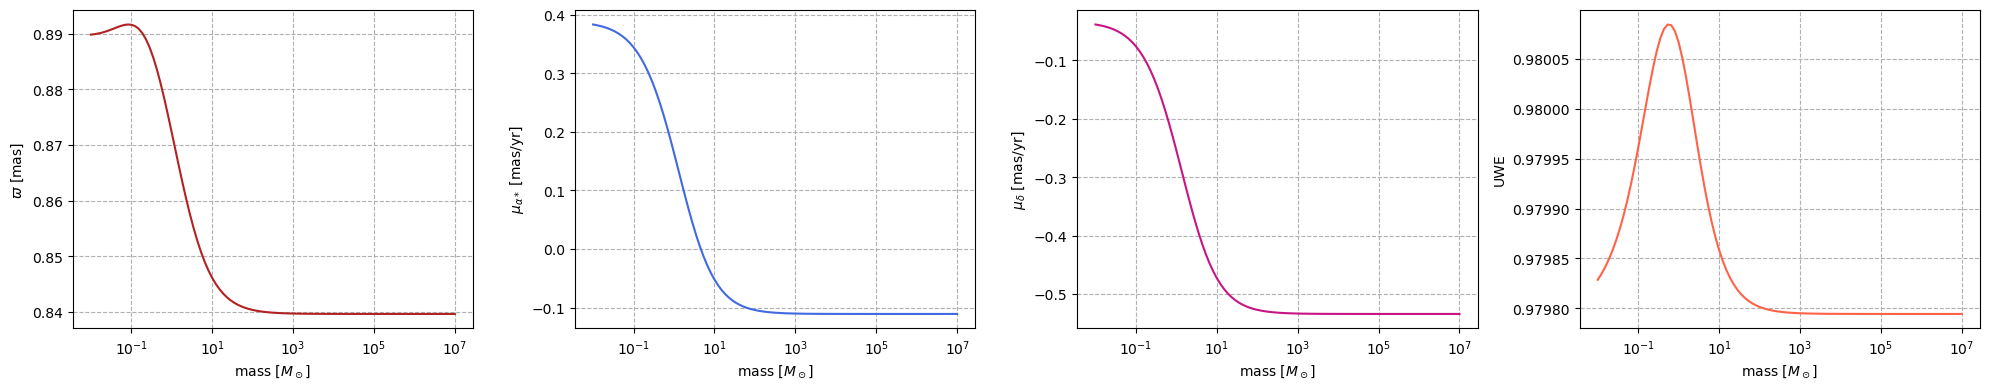

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

def plot_property(property_index, property_name, color):
    ax[property_index].plot(masses, different_masses[:, property_index], color=color);
    ax[property_index].set_xscale('log');
    ax[property_index].set_xlabel('mass [$M_\odot$]');
    ax[property_index].set_ylabel(property_name);
    ax[property_index].grid(linestyle='--');

plot_property(0, '$\\varpi$ [mas]', 'firebrick');
plot_property(1, '$\mu_{\\alpha*}$ [mas/yr]', 'royalblue');
plot_property(2, '$\mu_\delta$ [mas/yr]', 'mediumvioletred');
plot_property(3, 'UWE', 'tomato')
plt.tight_layout();

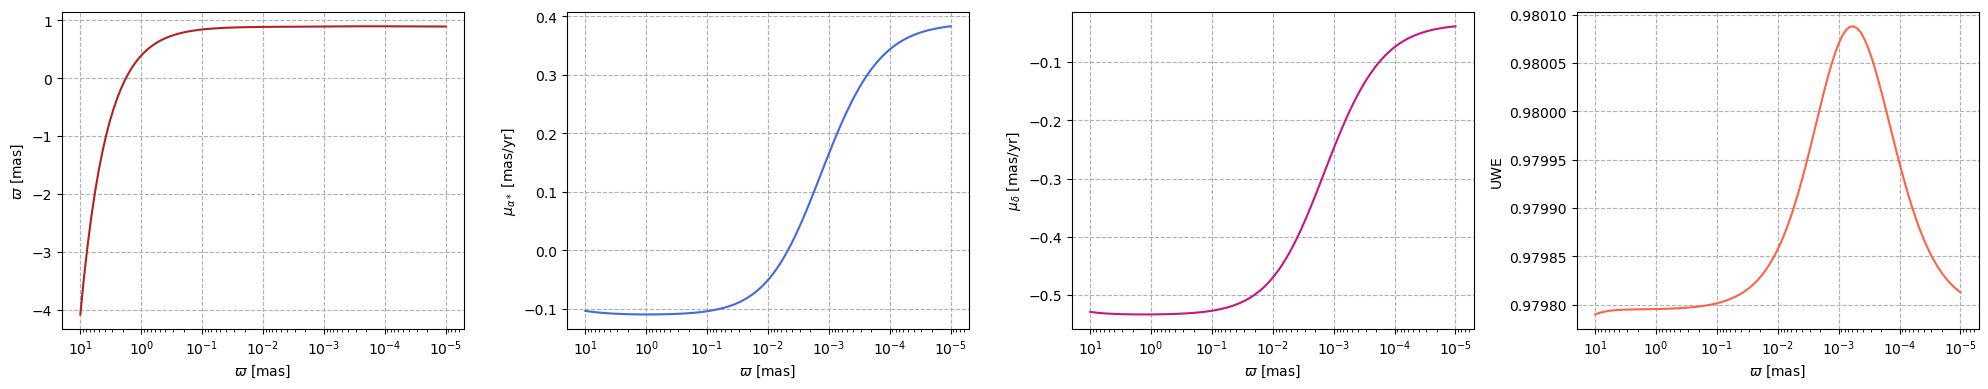

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

def plot_property_for_parallax(property_index, property_name, color):
    ax[property_index].plot(parallaxes, different_parallaxes[:, property_index], color=color);
    ax[property_index].set_xlabel('$\\varpi$ [mas]');
    ax[property_index].set_xscale('log');
    ax[property_index].invert_xaxis();
    ax[property_index].set_ylabel(property_name);
    ax[property_index].grid(linestyle='--');

plot_property_for_parallax(0, '$\\varpi$ [mas]', 'firebrick');
plot_property_for_parallax(1, '$\mu_{\\alpha*}$ [mas/yr]', 'royalblue');
plot_property_for_parallax(2, '$\mu_\delta$ [mas/yr]', 'mediumvioletred');
plot_property_for_parallax(3, 'UWE', 'tomato')
plt.tight_layout();

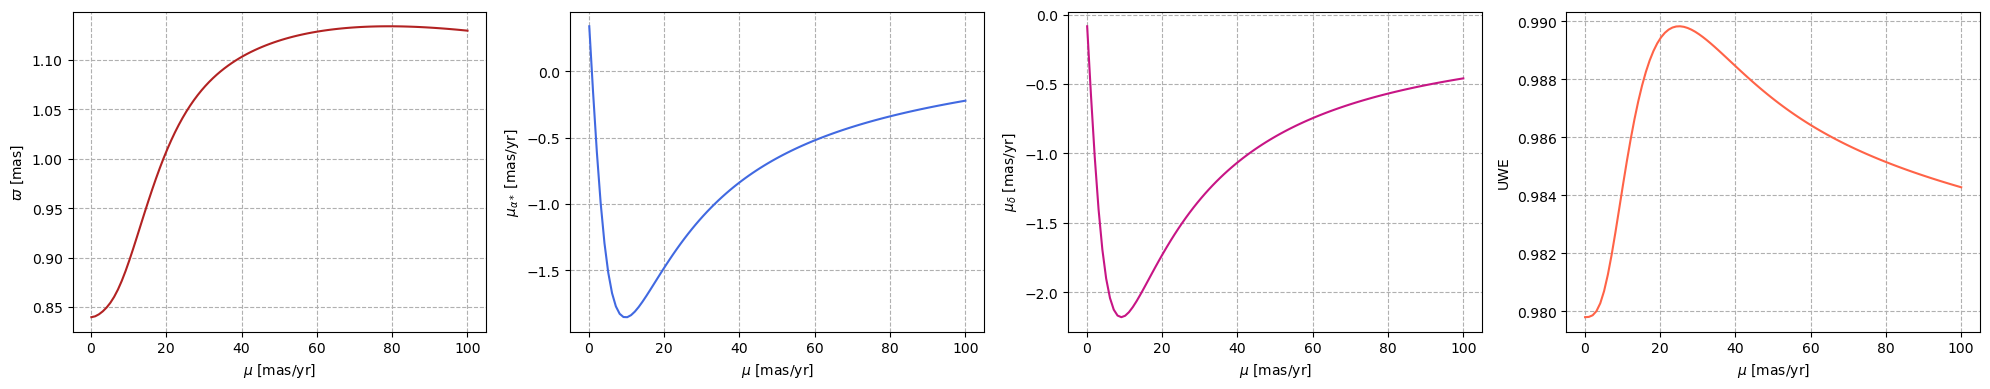

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

def plot_property_for_pmra(property_index, property_name, color):
    ax[property_index].plot(pms, different_pms[:, property_index], color=color);
    ax[property_index].set_xlabel('$\mu$ [mas/yr]');
    ax[property_index].set_ylabel(property_name);
    ax[property_index].grid(linestyle='--');

plot_property_for_pmra(0, '$\\varpi$ [mas]', 'firebrick');
plot_property_for_pmra(1, '$\mu_{\\alpha*}$ [mas/yr]', 'royalblue');
plot_property_for_pmra(2, '$\mu_\delta$ [mas/yr]', 'mediumvioletred');
plot_property_for_pmra(3, 'UWE', 'tomato')
plt.tight_layout();

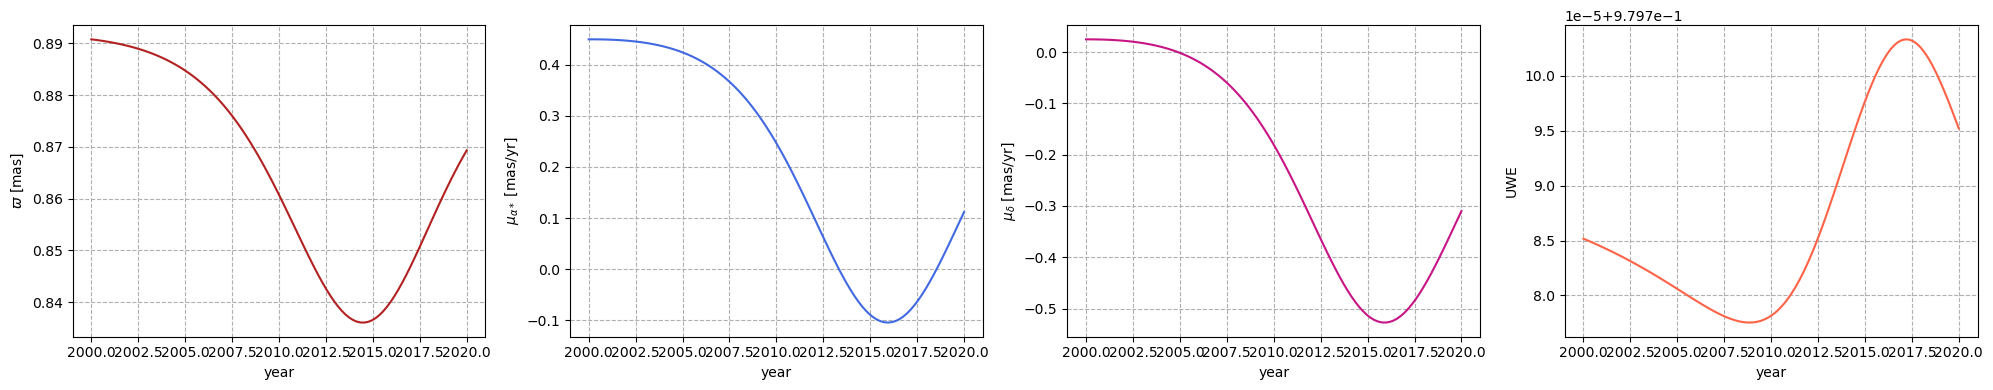

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

def plot_property_for_pmra(property_index, property_name, color):
    ax[property_index].plot(years, different_years[:, property_index], color=color);
    ax[property_index].set_xlabel('year');
    ax[property_index].set_ylabel(property_name);
    ax[property_index].grid(linestyle='--');

plot_property_for_pmra(0, '$\\varpi$ [mas]', 'firebrick');
plot_property_for_pmra(1, '$\mu_{\\alpha*}$ [mas/yr]', 'royalblue');
plot_property_for_pmra(2, '$\mu_\delta$ [mas/yr]', 'mediumvioletred');
plot_property_for_pmra(3, 'UWE', 'tomato')
plt.tight_layout();

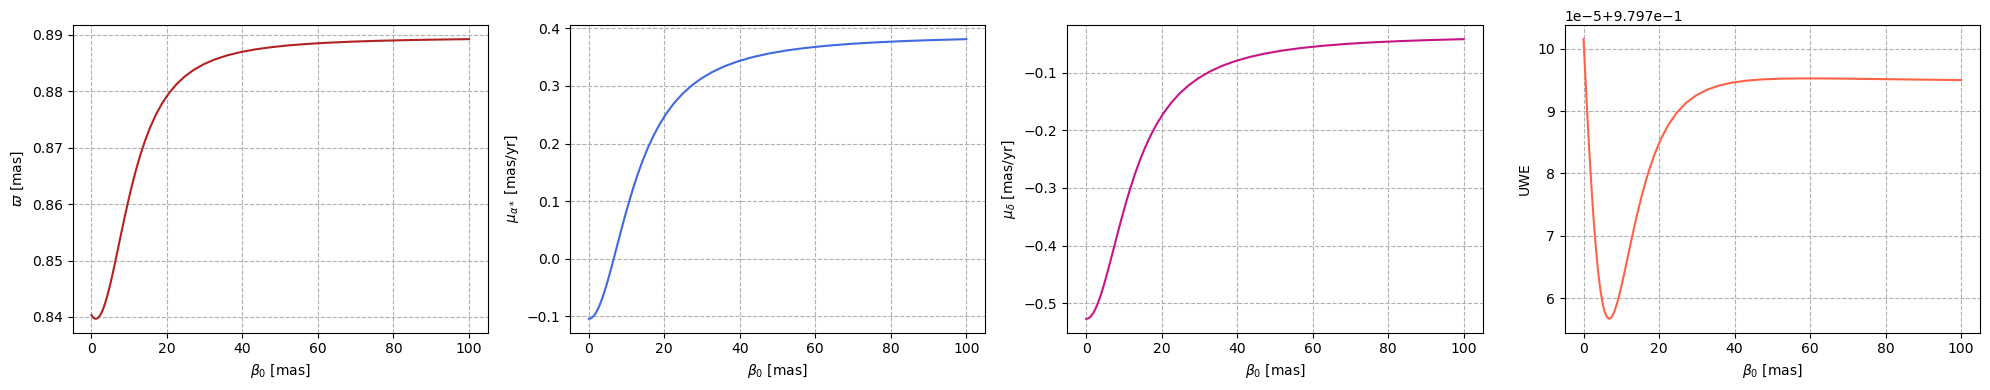

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

def plot_property_for_beta_0(property_index, property_name, color):
    ax[property_index].plot(beta_0s, different_beta_0s[:, property_index], color=color);
    ax[property_index].set_xlabel('$\\beta_0$ [mas]');
    ax[property_index].set_ylabel(property_name);
    ax[property_index].grid(linestyle='--');

plot_property_for_beta_0(0, '$\\varpi$ [mas]', 'firebrick');
plot_property_for_beta_0(1, '$\mu_{\\alpha*}$ [mas/yr]', 'royalblue');
plot_property_for_beta_0(2, '$\mu_\delta$ [mas/yr]', 'mediumvioletred');
plot_property_for_beta_0(3, 'UWE', 'tomato')
plt.tight_layout();